# Tratando dados

In [41]:
import pandas as pd
import numpy as np

In [145]:
saureus_features = pd.read_csv('saureus_genome_features.csv')

In [147]:
saureus_ppi = pd.read_csv('saureus_ppi_patric.csv')

In [148]:
saureus_ppi = saureus_ppi[['Interactor A ID', 'Interactor B ID']].astype("string")

In [149]:
saureus_ppi.head()

,Interactor A ID,Interactor B ID
0,fig|93061.5.peg.452,fig|93061.5.peg.713
1,fig|93061.5.peg.1920,fig|93061.5.peg.1921
2,fig|93061.5.peg.111,fig|93061.5.peg.119
3,fig|93061.5.peg.112,fig|93061.5.peg.121
4,fig|93061.5.peg.1069,fig|93061.5.peg.1071


In [150]:
plf = saureus_features[['BRC ID', 'PATRIC genus-specific families (PLfams)']].astype("string")

In [153]:
plf.set_index('BRC ID', inplace = True)

In [52]:
sa_specialty = pd.read_csv('saureus_specialty_genes.csv')

In [196]:
sa_specialty_genes = sa_specialty[['BRC ID', 'Property']]

In [54]:
sa_specialty_genes.set_index('BRC ID', inplace = True)

In [203]:
sa_specialty_genes.Property.unique()

array(['Antibiotic Resistance', 'Essential Gene', 'Virulence Factor',
       'Human Homolog', 'Drug Target', 'Transporter'], dtype=object)

In [66]:
sa_feature_importance = pd.read_excel('saureus_feature_importance.xlsx') #from the paper

Tenho:
- uma PPI primária (dados vindos do PATRIC, somente), interação em termos de PLFams
- PLFams indexados por BRC ID
- Specialty Genes indexados por BRC ID
- Famílias com feature importance associado para cada uma das 10 replicatas

Na rede de interação, a proteína de BRC ID fig|93061.5.peg.894 (linha 2085) não tem nenhuma família associada

In [130]:
saureus_ppi['Interactor B ID'].isin(plf.index)[saureus_ppi['Interactor B ID'].isin(plf.index)==False]

2085    False
Name: Interactor B ID, dtype: bool

Também não há função de interesse documentada para esta proteína em special features

In [169]:
sa_specialty[['BRC ID', 'Property']].loc[sa_specialty['BRC ID'] == saureus_ppi['Interactor B ID'].loc[2085]]

,BRC ID,Property


In [170]:
saureus_ppi.drop(2085, 0, inplace = True)

Agora, substituímos os features a PPI por famílias:

In [182]:
saureus_ppi_plfams = pd.DataFrame([plf.loc[saureus_ppi['Interactor A ID']].reset_index()['PATRIC genus-specific families (PLfams)'], plf.loc[saureus_ppi['Interactor B ID']].reset_index()['PATRIC genus-specific families (PLfams)']]).T

In [192]:
saureus_ppi_plfams.drop_duplicates(subset=None, keep='first', inplace=True)

In [214]:
saureus_ppi_plfams.columns = ['Interactor A ID', 'Interactor B ID']

# NetworkX

In [186]:
import networkx as nx
import scipy

In [215]:
ppi_graph = nx.from_pandas_edgelist(saureus_ppi_plfams, 'Interactor A ID', 'Interactor B ID')

In [216]:
ppi_graph.number_of_edges()

4971

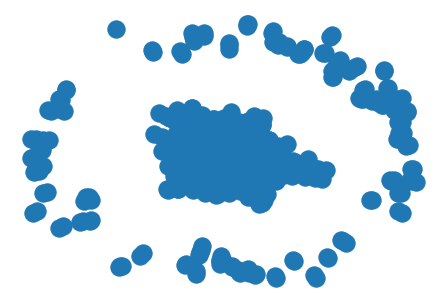

In [217]:
colors = ['blue' if node not in resistance_genes_ppi['Resistance Gene Family'] ]
nx.draw(ppi_graph, node_colors=colors)

## Genes de Resistência

In [204]:
sa_specialty_genes[sa_specialty_genes.Property == 'Antibiotic Resistance']

,BRC ID,Property
0,fig|1413510.3.peg.2169,Antibiotic Resistance
7,fig|93061.5.peg.1154,Antibiotic Resistance
10,fig|93061.5.peg.2089,Antibiotic Resistance
28,fig|93061.5.peg.842,Antibiotic Resistance
29,fig|158879.11.peg.1813,Antibiotic Resistance
...,...,...
1936,fig|158879.11.peg.2331,Antibiotic Resistance
1938,fig|1241616.6.peg.1396,Antibiotic Resistance
1940,fig|158879.11.peg.647,Antibiotic Resistance
1947,fig|158879.11.peg.2107,Antibiotic Resistance


In [239]:
resistance_genes = plf.loc[sa_specialty_genes['BRC ID'].loc[sa_specialty_genes.Property == 'Antibiotic Resistance']].reset_index()

In [281]:
#resistance genes that are in the network ppi
resistance_genes_ppi_A = resistance_genes[resistance_genes['PATRIC genus-specific families (PLfams)'].isin(saureus_ppi_plfams['Interactor A ID'])]
resistance_genes_ppi_B = resistance_genes[resistance_genes['PATRIC genus-specific families (PLfams)'].isin(saureus_ppi_plfams['Interactor B ID'])]

resistance_genes_ppi = pd.concat([resistance_genes_ppi_A, resistance_genes_ppi_B], axis = 0).drop_duplicates('PATRIC genus-specific families (PLfams)')

In [286]:
resistance_genes_ppi.columns = ['BRC ID', 'Resistance Gene Family']

In [280]:
#families from the paper that are in the network ppi
sa_paper_in_ppi_A = sa_feature_importance[sa_feature_importance['Protein Family ID'].isin(saureus_ppi_plfams['Interactor A ID'])]['Protein Family ID']
sa_paper_in_ppi_B = sa_feature_importance[sa_feature_importance['Protein Family ID'].isin(saureus_ppi_plfams['Interactor B ID'])]['Protein Family ID']

sa_paper_in_ppi = pd.concat([sa_paper_in_ppi_A, sa_paper_in_ppi_B], axis = 0).drop_duplicates()

In [287]:
ppi_graph.degree(resistance_genes_ppi['Resistance Gene Family'])

DegreeView({'PLF_1279_00000401': 23, 'PLF_1279_00004269': 3, 'PLF_1279_00000448': 3, 'PLF_1279_00015910': 6, 'PLF_1279_00001562': 2, 'PLF_1279_00000310': 1, 'PLF_1279_00001271': 18, 'PLF_1279_00000971': 4, 'PLF_1279_00001615': 6, 'PLF_1279_00001556': 7, 'PLF_1279_00000115': 5, 'PLF_1279_00000469': 15, 'PLF_1279_00000085': 8, 'PLF_1279_00000217': 27, 'PLF_1279_00001495': 2, 'PLF_1279_00000489': 4, 'PLF_1279_00000164': 13, 'PLF_1279_00000783': 11, 'PLF_1279_00000570': 33, 'PLF_1279_00001926': 8, 'PLF_1279_00001367': 3, 'PLF_1279_00006163': 9, 'PLF_1279_00000571': 4, 'PLF_1279_00000311': 30, 'PLF_1279_00000484': 9, 'PLF_1279_00000320': 16, 'PLF_1279_00000284': 22, 'PLF_1279_00025736': 8, 'PLF_1279_00000782': 10, 'PLF_1279_00000281': 16, 'PLF_1279_00000173': 13, 'PLF_1279_00000434': 6, 'PLF_1279_00001527': 13, 'PLF_1279_00002044': 7, 'PLF_1279_00000503': 6, 'PLF_1279_00000415': 26, 'PLF_1279_00002337': 1, 'PLF_1279_00000795': 5, 'PLF_1279_00000784': 9, 'PLF_1279_00002294': 2, 'PLF_1279_000

In [294]:
for i in resistance_genes_ppi['Resistance Gene Family']:
    for j in sa_paper_in_ppi:
        if nx.has_path(ppi_graph, i, j):
            print(nx.shortest_path_length(ppi_graph, i, j))
        

4
3
3
4
4
4
3
4
3
4
4
4
4
3
3
3
4
3
3
2
3
4
2
3
3
1
4
3
4
3
2
3
2
2
1
4
3
2
3
3
3
4
1
1
2
4
3
4
3
4
4
3
3
4
2
4
4
3
5
3
4
3
3
5
5
4
5
3
3
4
5
4
4
2
6
2
3
4
3
3
5
4
5
4
4
4
4
4
4
2
3
3
5
3
3
4
1
6
5
5
1
2
4
2
2
4
4
2
2
3
4
4
3
5
3
4
6
4
3
4
4
3
4
4
3
3
5
3
4
3
3
3
4
4
5
4
3
4
4
4
3
3
5
3
4
4
4
3
3
5
2
3
2
4
4
6
2
3
3
4
5
4
3
3
2
4
3
3
3
3
2
4
3
4
3
3
6
5
3
5
5
3
3
2
4
4
4
4
2
4
3
8
4
5
7
3
3
3
2
3
5
4
4
5
4
4
4
4
4
4
4
3
3
2
3
1
3
3
6
2
4
4
4
4
3
2
4
3
5
5
3
6
3
3
3
3
6
3
4
4
2
3
4
4
5
4
3
2
3
2
4
3
2
2
4
2
3
4
4
4
4
6
3
4
4
4
2
4
3
2
2
2
4
5
4
5
4
5
4
4
3
4
4
3
3
4
3
3
4
5
5
3
3
4
4
3
3
4
3
4
3
5
3
4
4
3
5
3
2
4
1
4
3
4
2
4
3
2
4
4
1
4
4
3
4
5
7
2
3
2
4
4
4
2
5
3
3
4
4
4
5
2
3
4
5
3
5
4
4
5
3
4
5
2
3
4
4
3
2
4
4
4
4
3
3
2
5
5
3
5
4
4
5
2
4
3
4
4
3
3
3
3
3
2
3
4
3
3
4
3
3
3
3
3
5
4
3
4
4
3
4
4
5
3
4
4
3
3
4
5
3
5
3
4
3
5
4
5
3
4
4
3
2
3
3
6
4
2
4
2
4
4
3
4
4
3
3
3
4
4
3
6
3
4
4
4
4
4
3
4
3
2
3
3
3
3
3
3
6
3
6
3
4
4
5
2
4
4
4
2
5
3
4
5
2
4
3
2
2
3
5
4
4
3
3
3
4
4
3
4
2
3
5
2
3
2
3
2
4
5


3
5
3
3
5
5
6
5
5
6
4
5
5
5
4
5
4
5
5
5
3
5
5
4
4
5
4
4
5
5
5
4
5
4
5
4
4
5
5
5
3
6
6
5
4
5
5
4
5
5
4
6
7
5
5
5
4
6
4
4
5
6
4
3
4
6
5
6
6
5
6
5
5
5
7
5
7
5
4
5
5
4
6
5
5
4
4
6
5
6
5
2
4
4
5
4
4
6
4
6
5
7
5
5
3
5
4
5
6
4
5
4
5
5
5
6
4
4
8
3
2
4
6
5
6
4
4
6
6
4
5
3
5
5
7
5
4
5
4
4
6
6
4
4
7
5
5
6
4
5
3
5
4
6
4
5
3
7
5
4
5
5
6
4
5
4
4
4
3
3
6
3
5
5
4
4
5
5
7
6
5
6
5
5
3
4
6
5
4
7
4
4
4
9
5
5
8
5
4
4
5
5
7
6
5
6
7
5
4
6
4
5
6
4
3
4
4
4
4
5
7
4
4
5
6
4
4
4
5
4
6
6
5
3
3
5
5
5
7
5
7
4
5
4
5
3
6
6
4
4
5
4
4
4
5
4
4
6
4
4
4
4
4
6
5
4
5
3
5
5
4
4
4
4
5
5
6
6
4
6
5
5
4
5
6
5
5
5
4
2
4
6
6
5
4
4
5
3
3
5
4
4
5
5
5
7
3
4
6
5
5
3
4
5
6
6
5
5
4
4
5
6
3
5
5
5
5
6
6
5
4
4
6
7
5
5
7
5
5
5
5
6
5
4
5
6
6
4
6
5
4
5
6
5
6
4
5
6
5
3
4
5
5
5
5
5
3
5
7
5
5
4
7
5
6
5
5
4
3
6
5
5
6
4
4
4
6
3
5
5
5
3
5
5
5
4
6
4
4
5
4
5
5
6
6
4
5
4
5
5
5
6
4
6
4
4
5
5
5
6
4
5
5
4
3
3
3
7
5
5
4
4
5
5
6
5
5
4
5
3
6
5
5
7
4
2
4
5
5
6
3
5
4
3
3
3
4
5
4
5
7
4
7
4
7
5
5
4
4
4
5
3
6
3
4
7
4
5
5
4
5
5
6
4
3
4
3
4
4
5
4
5
5
4
5
4
5
5
5
5


6
7
9
6
6
5
7
6
6
6
7
5
6
6
7
6
6
7
5
4
5
7
6
8
8
6
7
6
7
6
6
7
6
7
7
8
6
6
6
8
5
6
7
6
6
6
6
5
7
6
10
6
5
5
7
5
4
7
7
7
6
7
6
8
7
6
4
7
7
5
6
7
6
6
6
5
5
8
7
6
2
6
5
7
7
4
3
4
4
5
5
3
4
3
4
4
4
4
3
5
5
4
4
2
3
4
5
3
3
3
3
4
4
5
5
4
4
3
3
3
3
4
3
4
3
3
6
3
3
4
5
4
4
4
5
5
4
4
3
3
5
5
4
6
3
4
4
4
4
6
4
6
4
5
4
5
5
5
3
5
4
4
5
4
3
4
5
6
2
5
6
4
5
4
3
3
4
3
2
5
6
3
7
3
6
2
3
5
3
4
4
5
3
3
3
5
4
4
4
4
2
7
3
4
3
4
3
5
4
3
5
5
3
3
1
3
4
4
5
6
4
5
4
5
5
4
3
6
4
4
4
4
3
4
5
3
4
3
4
2
6
2
3
4
5
6
4
3
4
3
3
4
5
5
4
4
4
4
4
4
3
7
4
5
6
5
5
3
3
4
4
2
6
2
5
4
8
4
6
7
4
4
5
3
3
6
5
5
6
6
4
4
6
5
4
4
3
4
3
4
3
4
4
7
3
4
3
5
5
2
4
4
4
6
6
3
7
3
4
4
3
7
3
4
4
4
3
4
4
5
5
4
3
4
4
5
4
3
3
5
3
3
4
6
4
5
7
3
4
3
4
3
5
4
4
3
3
4
6
5
5
5
5
4
4
3
3
6
4
3
3
3
3
5
4
6
3
3
2
4
4
4
4
3
4
3
4
4
5
5
4
6
4
3
3
3
4
4
5
3
5
3
3
5
5
3
4
5
2
5
5
6
3
3
4
4
5
4
3
6
4
3
5
5
5
7
3
4
5
4
4
5
5
5
5
4
3
5
3
2
5
5
4
4
4
4
4
5
4
4
3
6
6
5
6
5
5
6
4
4
3
4
5
5
3
3
4
2
4
5
5
4
4
3
5
4
4
4
3
5
4
3
4
5
4
3
5
5
4
4
3
4
4
3
6
4
5
4
5
4

5
5
4
4
4
6
5
5
6
5
5
5
3
4
6
4
6
3
5
5
4
4
5
5
6
4
2
6
5
4
5
4
3
4
5
4
5
6
4
7
4
7
4
4
4
5
5
5
5
4
4
4
5
5
5
6
2
4
8
3
4
5
5
5
6
4
4
5
5
3
5
3
5
4
6
4
4
5
2
4
6
6
5
4
6
4
5
7
5
4
3
4
3
5
4
5
4
6
4
4
4
5
5
3
4
4
4
4
3
4
5
3
4
5
4
4
4
4
7
5
4
5
5
5
3
4
5
5
3
6
4
5
4
8
5
6
7
4
4
5
4
4
6
6
5
6
7
5
5
6
3
5
5
4
3
4
5
4
3
4
7
4
4
5
6
4
4
5
5
4
6
6
4
5
3
4
5
4
7
4
6
5
4
4
4
4
5
6
4
4
4
3
4
3
4
3
5
5
4
4
5
4
4
6
5
4
5
3
4
4
4
4
4
4
5
4
6
6
4
5
4
5
4
4
7
5
5
5
4
2
4
6
6
5
3
4
5
2
3
4
4
5
5
5
3
6
3
4
5
4
4
4
3
4
5
6
4
5
4
4
4
5
4
5
5
4
3
5
7
4
4
5
6
6
5
5
7
4
5
5
5
5
6
4
5
6
6
4
6
6
4
3
5
4
5
3
4
7
3
3
5
4
5
5
5
4
4
4
6
3
3
4
6
5
4
4
5
4
4
6
4
5
6
4
4
5
5
3
5
5
5
4
4
5
4
4
6
4
3
5
3
5
5
5
5
4
4
4
5
4
5
5
4
6
4
4
5
5
5
6
4
4
4
4
3
4
5
7
5
5
5
4
3
3
5
4
5
4
5
4
7
5
4
7
4
4
4
5
5
6
4
5
5
3
3
4
4
5
4
4
6
4
7
5
5
4
4
5
6
2
3
4
6
3
5
7
3
5
4
4
4
4
6
4
3
3
4
4
3
4
4
5
4
3
6
4
4
4
4
5
4
5
3
4
3
4
3
4
5
6
5
4
4
3
3
6
3
5
3
4
3
5
4
4
5
5
1
5
3
5
5
3
5
4
6
4
5
3
5
4
3
3
5
5
4
6
5
5
4
5
4
4
5
5
5
4
4
4
6
4


5
3
3
5
4
5
3
2
4
5
4
4
2
2
3
4
3
4
5
3
6
5
5
2
2
4
3
4
4
4
3
3
3
4
4
4
5
4
3
6
3
3
4
4
3
4
4
2
4
5
2
4
2
3
2
4
4
5
3
2
3
5
4
3
3
4
2
5
5
4
2
3
4
3
4
2
3
3
5
3
3
3
5
5
3
3
4
3
2
4
2
4
3
2
4
3
3
3
3
6
5
4
5
4
4
3
3
4
4
4
5
4
3
3
8
4
5
7
3
3
4
3
4
4
4
4
5
5
3
4
5
3
3
4
3
4
3
4
3
3
2
6
3
4
4
5
4
3
3
4
3
5
6
3
7
4
2
4
2
6
3
5
3
3
3
4
4
4
4
3
3
3
3
4
3
3
2
4
3
3
4
4
4
4
4
3
5
4
4
3
4
3
3
3
3
4
4
4
5
4
3
3
5
3
4
6
3
3
4
3
4
2
5
6
4
3
3
4
3
4
3
3
4
3
3
3
5
4
4
5
3
4
4
3
4
4
5
2
4
4
2
4
5
3
4
4
4
5
4
7
2
3
3
4
4
3
3
5
3
3
4
5
4
4
4
3
4
5
4
4
4
4
3
4
5
4
3
4
5
3
4
4
3
4
3
4
3
3
2
4
3
3
6
5
4
6
2
3
3
4
5
3
4
4
3
3
4
3
4
4
3
4
4
2
3
3
4
5
4
3
5
4
3
4
3
4
4
3
4
3
2
5
5
3
5
3
2
4
4
4
5
4
4
4
4
3
2
3
6
4
3
4
2
3
3
3
3
3
2
3
2
5
4
2
5
3
4
5
5
4
5
4
4
3
3
3
4
3
4
3
3
6
3
6
3
5
3
4
3
4
2
5
3
6
3
4
5
2
4
3
3
2
3
5
4
4
3
4
4
4
3
2
4
3
3
5
2
3
3
4
3
3
5
4
3
1
2
3
3
4
4
4
3
4
5
3
4
2
3
2
3
4
3
4
2
3
3
3
4
3
5
3
3
3
3
4
3
5
1
4
3
3
4
5
3
5
4
5
4
4
3
4
2
3
4
4
3
2
3
4
5
5
3
4
4
4
5
4
5
4
5
3
3
3
4
5
5
6
5
6


8
7
6
7
5
7
7
6
5
6
6
9
5
7
5
8
8
6
7
7
6
8
8
6
9
6
6
7
6
9
6
8
6
6
6
7
7
7
7
6
5
6
6
8
4
5
6
7
6
7
5
7
7
5
7
6
7
6
6
6
7
6
6
5
6
7
7
7
8
5
8
6
8
5
5
8
6
6
5
7
6
5
8
9
5
6
6
6
7
7
6
6
7
6
6
6
8
8
7
8
6
6
7
6
7
7
8
5
7
6
5
7
8
5
7
7
6
8
7
10
5
5
7
7
7
6
5
8
6
6
7
7
7
7
6
6
7
4
7
8
7
5
7
7
7
7
5
6
8
6
7
6
6
7
5
6
6
5
5
7
7
5
8
8
7
9
6
6
6
7
7
7
7
7
6
5
6
7
8
7
6
7
7
6
6
7
7
8
6
6
7
7
6
7
6
7
7
7
6
6
6
7
8
6
8
6
5
7
7
6
8
7
7
7
8
6
5
6
9
7
5
7
5
7
6
6
7
6
7
7
5
8
6
7
8
6
7
7
7
6
8
5
7
6
6
6
5
5
7
6
6
8
6
9
6
8
7
8
6
7
6
7
6
8
7
8
9
6
7
7
6
6
6
8
7
7
6
5
7
7
7
6
7
6
6
8
5
6
5
5
7
6
8
6
6
6
5
4
6
7
7
7
6
7
7
5
7
5
5
4
6
6
7
6
5
5
6
6
7
7
8
7
6
7
6
7
5
7
6
7
5
6
7
6
5
6
7
8
7
7
6
7
5
7
7
7
7
5
6
7
7
8
5
8
7
7
7
8
8
6
8
6
6
6
6
7
8
8
7
9
6
6
6
9
6
6
7
7
6
7
7
6
7
7
9
7
8
6
8
8
9
8
7
6
9
7
8
8
9
6
7
7
8
7
7
8
7
5
6
6
8
8
7
6
4
6
6
7
1
8
8
7
8
6
7
7
7
9
7
7
8
10
8
6
7
7
8
7
7
7
6
6
7
7
8
7
10
6
6
7
8
6
6
7
6
8
6
7
7
9
7
8
5
8
9
7
7
8
7
6
6
6
6
9
8
7
7
6
6
7
8
5
5
5
5
5
5
4
4
4
5
6
5
4
5
6
5
4
4

3
3
4
5
3
5
3
7
4
5
6
2
3
3
3
3
5
5
4
6
6
3
4
6
5
4
4
2
4
3
4
3
3
3
6
3
4
4
5
5
2
3
4
4
5
5
3
7
4
2
4
3
6
1
4
4
4
4
4
3
5
5
3
2
2
3
3
3
3
1
4
3
2
4
5
4
4
6
4
5
4
3
3
4
3
4
3
3
5
4
5
3
4
5
4
4
2
4
6
3
3
4
2
3
4
4
5
4
3
3
5
4
4
4
3
4
3
5
3
5
3
4
5
3
4
4
3
3
4
5
3
5
3
3
4
5
3
4
5
4
5
5
7
3
3
3
4
5
4
3
6
4
3
4
4
5
6
3
4
5
5
4
3
5
4
4
4
5
4
2
4
5
5
4
4
3
4
4
4
3
3
3
5
5
4
6
4
5
6
3
4
3
3
5
4
4
3
4
3
4
5
3
3
3
4
4
3
4
3
3
4
4
3
5
5
3
4
4
4
4
4
4
4
4
3
5
3
5
4
4
4
4
4
4
3
4
4
4
3
4
3
7
5
3
4
3
4
4
3
4
3
3
3
4
5
3
2
4
4
4
5
5
4
6
3
4
4
2
1
4
3
4
3
4
6
4
6
3
5
4
5
4
4
3
4
3
6
4
4
5
3
4
4
2
3
3
3
4
3
3
4
5
4
4
3
5
3
3
5
4
4
4
4
4
2
5
4
3
3
3
3
4
5
4
4
3
2
5
4
3
3
4
3
2
4
4
3
3
2
4
3
4
4
4
2
3
3
3
4
3
5
3
3
2
3
5
4
4
4
5
4
4
4
3
4
2
3
5
3
4
3
3
3
5
4
3
6
4
4
5
5
4
5
6
4
4
3
4
5
4
6
5
7
3
4
3
6
4
4
4
5
5
5
4
4
5
4
4
5
6
3
4
5
6
4
4
5
5
4
3
5
4
4
3
4
4
5
4
6
3
3
4
3
5
6
5
2
3
4
4
5
4
6
5
4
4
5
5
5
4
7
4
4
4
6
4
4
4
6
4
4
4
4
3
4
4
5
5
4
8
4
3
5
5
3
4
4
4
5
4
4
4
5
4
4
3
5
6
5
4
4
4
4
3
5
4
6
6
4
5


In [295]:
for i in resistance_genes_ppi['Resistance Gene Family']:
    for j in resistance_genes_ppi['Resistance Gene Family']:
        if nx.has_path(ppi_graph, i, j):
            print(nx.shortest_path_length(ppi_graph, i, j))

0
4
3
4
4
3
4
4
4
4
3
3
2
4
2
1
4
1
3
5
3
3
2
3
4
1
4
3
2
3
3
3
3
4
2
5
4
3
5
3
8
4
2
4
0
5
5
6
5
5
5
5
5
4
3
3
7
4
4
5
3
5
6
5
5
4
3
4
4
6
5
4
5
5
4
6
4
4
7
4
2
7
4
10
5
2
3
5
0
5
5
5
5
5
5
4
2
4
3
6
3
3
5
2
4
6
4
5
1
4
5
3
5
5
4
2
5
4
5
5
3
6
4
4
5
4
9
5
3
4
5
5
0
4
5
5
5
5
5
5
3
4
4
5
4
4
4
5
5
3
5
4
3
6
4
2
2
3
4
3
5
3
4
4
6
6
5
6
5
6
4
4
0
4
6
5
4
0
5
5
5
5
5
5
5
5
6
6
5
5
5
6
7
4
6
4
5
7
5
4
4
5
4
5
5
5
6
5
8
6
5
7
6
8
6
5
3
5
5
5
5
0
2
2
2
4
3
5
3
4
4
3
1
3
4
2
2
2
4
5
3
3
4
3
3
4
3
1
3
5
2
7
5
5
4
4
8
1
4
4
5
5
5
5
2
0
2
2
4
4
4
3
5
4
3
2
4
4
4
3
1
4
4
4
3
4
4
2
4
4
1
4
5
3
6
5
4
5
4
8
3
4
4
5
5
5
5
2
2
0
1
4
5
4
3
5
4
5
1
4
4
4
2
2
4
4
5
4
4
3
4
4
3
1
4
5
4
7
5
4
6
4
8
3
4
4
5
5
5
5
2
2
1
0
4
5
5
4
5
4
5
1
4
4
4
2
2
4
4
5
4
4
3
4
4
3
1
4
6
4
7
5
4
6
5
8
3
4
4
5
4
5
5
4
4
4
4
0
4
4
4
6
3
4
4
4
5
6
4
4
3
4
5
4
5
5
4
4
4
3
5
5
4
5
5
4
4
5
9
5
4
3
4
2
5
5
3
4
5
5
4
0
3
3
5
3
3
4
2
4
4
4
5
1
3
4
2
3
4
3
2
4
4
4
4
3
6
3
3
5
4
7
3
3
3
3
4
3
5
5
4
4
5
4
3
0
2
6
3
2
5
3
5
5
4
4
3
2
4
3